In [1]:
!apt-get update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!pip install gym[atari]
!pip install torchtrainer

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [52.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ge

In [2]:
!pip install pybullet

     |████████████████████████████████| 89.3MB 48kB/s 


In [3]:
!git clone https://github.com/benelot/pybullet-gym.git

Cloning into 'pybullet-gym'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 804 (delta 21), reused 13 (delta 5), pack-reused 750
Receiving objects: 100% (804/804), 19.31 MiB | 25.16 MiB/s, done.
Resolving deltas: 100% (437/437), done.


In [4]:
cd /content/pybullet-gym/

/content/pybullet-gym


In [5]:
!pip install -e .

Obtaining file:///content/pybullet-gym
  Running setup.py develop for pybulletgym


In [6]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import pybulletgym  # register PyBullet enviroments with open ai gym
import pybullet
import pybullet_data

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import time
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count

# Colab comes with PyTorch
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

In [7]:
class Q_Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(5, 125), # 4 observations and 1 action
        nn.LeakyReLU(),
        nn.Linear(125, 125), # Hidden layers
        nn.LeakyReLU(),
        nn.Linear(125, 1), # Q value
    )

  def forward(self, x):
    return self.layers(x)

## InvertedPendulumMuJoCoEnv-v0
InvertedPendulumMuJoCoEnv-v0 is used in the example, the action space is a single float value in (-1, 1), observation space is a tuple consists of 4 vals.


The reward is 1, for each step that not lead to end of game. The goal for this game is to survive as many steps as possible


Since MC only work in descrete domain, action space and observation space was splitted by a step of 0.1

### Monte Carlo

In [14]:
class MCMethod:
  def __init__(self, n_episode, n_max_step, gamma):
    self.episode = n_episode
    self.maxStep = n_max_step
    self.gamma = gamma
    self.replayDict = {}
    self.history = []
  
  def updatePolicy(self, replayBuffer):
    replayBuffer = replayBuffer[::-1]
    previous_r = 0
    for s, a, r in replayBuffer:
      s = np.round(s, 1)
      a = a[0]
      sum_r = self.gamma*previous_r + r
      previous_r = sum_r
      s = str(s)
      if s in self.replayDict:
        if a in self.replayDict[s]:
          q, c = self.replayDict[s][a]
          self.replayDict[s][a] = ((q*c+sum_r)/(c+1), c+1)
        else:
          self.replayDict[s][a] = (sum_r, 1)
      else:
        self.replayDict[s] = {}
        self.replayDict[s][a] = (sum_r, 1)
  
  def chooseAction(self, state):
    try:
      s = np.round(state, 1)
      s = str(s)
      actions = self.replayDict[s]
      if len(actions) < 8:
        return np.round(self.env.action_space.sample(), 1)
      max_step = np.round(self.env.action_space.sample(), 1)
      max_reward = 0
      for key in actions.keys():
        q, c = actions[key]
        if q > max_reward:
          max_reward = q
          max_step = key
      return np.array([max_step])
    except KeyError:
      return np.round(self.env.action_space.sample(), 1)


  def run(self):
    self.env = gym.make("InvertedPendulumMuJoCoEnv-v0")
    t = 0
    for i_epoch in range(self.episode):
      observation = self.env.reset() # reset environment
      buffer = []
      step = 0
      while True:
        self.env.render()
        s = observation
        a = self.chooseAction(s)

        observation, r, done, info = self.env.step(a) # s_prime: next observation, r: immediate reward, done: terminal state indicator
        buffer.append((s, a, r))
        t += 1
        step += 1
        # Ends this episode if reaching a terminal state
        if done:
          self.updatePolicy(buffer)
          break
      if i_epoch%self.maxStep == self.maxStep-1 :
        self.history.append(t/self.maxStep)
        print("average reward %d"%(t/self.maxStep))
        t = 0
      #print(self.replayDict)
      #print(self.decisionDict)
    
  def plot(self):
    epochs = np.arange(self.maxStep, self.episode+1, self.maxStep)
    plt.plot(epochs, self.history)

average reward 57
average reward 99
average reward 119
average reward 143
average reward 146
average reward 155
average reward 164
average reward 166
average reward 166
average reward 171


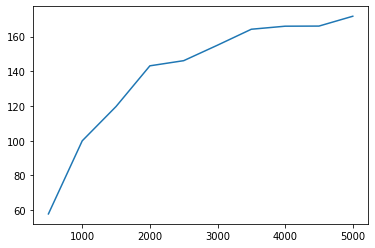

In [15]:
model = MCMethod(5000, 500, 0.2)
model.run()
model.plot()

### DQN

In [16]:
import copy # Use for target network copying & updating procedure
class DQNMethod:
  def __init__(self, n_episode, n_max_step, gamma, lr = 0.01):
    self.episode = n_episode
    self.maxStep = n_max_step
    self.gamma = gamma
    self.model = Q_Net()
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr)
    self.loss_fn = torch.nn.MSELoss(reduction='mean')
    self.exploringCount = 1000
    self.transactionBuffer = [] # used for Q model bootstrapping
    self.targetModel = None
    self.bestModel = None
    self.bestEval = 0
    self.history = []

  def saveData(self, replay):
    previous_s = None
    for s, a, r in replay:
      self.transactionBuffer.append((s, a, previous_s, r))
      previous_s = s

  
  def getQ(self, state):
    possibleActon = [i/10 for i in range(-10, 11)]
    if self.targetModel == None:
      return 0
    else:
      pending_data = []
      for action in possibleActon:
        pending_data.append(list(state) + [action])
      q = self.targetModel(torch.Tensor(pending_data)).tolist()
      q = np.array(q).reshape(-1)
      return np.max(q)

  def update_model(self, replay):
    self.saveData(replay)
    trainSet = []
    v_prev = 0
    for s, a, next_s, r in self.transactionBuffer:
      if next_s is None:
        q_prev = 0
      else:
        q_prev = max(self.getQ(next_s), v_prev)
      trainSet.append((list(s)+list(a), r+self.gamma*q_prev))
      v_prev = r
    self.transactionBuffer = [] # clear buffer
    self.train_model(trainSet)

  def bootstrapStep(self):    
    self.targetModel = copy.deepcopy(self.model)
    self.targetModel.eval()

  def train_model(self, dataset, epochs = 1):
    for _ in range(epochs):
      random.shuffle(dataset)
      data = []
      label = []
      for idx in range(len(dataset)):
        data.append(dataset[idx][0])
        label.append(dataset[idx][1])
      data = torch.Tensor(data)
      label = torch.Tensor(label)
      epoch_loss = 0.0
      for idx in range(len(data)):
        y_pred = self.model(data[idx])
        loss = self.loss_fn(y_pred, torch.tensor([label[idx]]))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        epoch_loss += loss.item()
    #print("loss %.6f"%(epoch_loss/epochs))

  def chooseAction(self, state):
    possible_action = [i/10 for i in range(-10, 11)]
    if self.targetModel == None or random.random() < 0.05: # the policy have a prob of 5% to select random action to explore the environment while bootstraping
      return np.array([random.choice(possible_action)])
    data = []
    for action in possible_action: # Slicing the actions with 0.01 step in (-1,1)
      data.append(list(state)+list([action]))
    idx = np.argmax(np.array(self.targetModel(torch.Tensor(data)).tolist()).reshape(-1)) # evaluate the actions and select the one with most Q
    selection = possible_action[idx]
    return np.array([selection]) # avoid model return value out of (-1, 1)

  def run(self):
    self.env = gym.make("InvertedPendulumMuJoCoEnv-v0")
    t = 0
    for i_episode in range(self.episode):
      observation = self.env.reset() # reset environment
      buffer = []
      step = 0
      while True:
        self.env.render()
        s = observation
        a = self.chooseAction(s)

        observation, r, done, info = self.env.step(a) # s_prime: next observation, r: immediate reward, done: terminal state indicator
        buffer.append((s, a, r))
        t += 1
        step += 1
        # Ends this episode if reaching a terminal state
        if done:
          self.update_model(buffer)
          break
      if i_episode % self.maxStep == self.maxStep-1:
        self.bootstrapStep()
        print("average survived step", t/self.maxStep)
        self.history.append(t/self.maxStep)
  
  def plot(self):
    epochs = np.arange(self.maxStep, self.episode+1, self.maxStep)
    plt.plot(epochs, self.history)

average survived step 25.298
average survived step 36.326
average survived step 64.462
average survived step 86.77
average survived step 104.726
average survived step 122.028
average survived step 136.608
average survived step 146.108
average survived step 162.48
average survived step 174.16


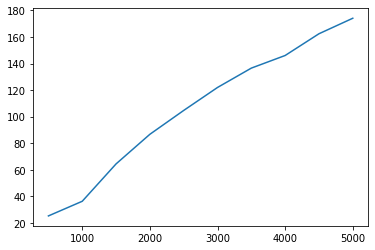

In [17]:
"""
evaluate your algorithm here
"""
model = DQNMethod(5000, 500, 0.2, lr=0.01)
model.run()
model.plot()